# Exploration
This notebook is used for data exploration for this fraud detection project.

In [6]:
import numpy as np
import pandas as pd
import sqlite3, math
import xgboost as xgb
#from preprocessing.preprocessor import Preprocessor

In [7]:
# make sqlite database out of raw data
# TODO: do this for all csv files, make separate train and test databases
  
# Connect to SQLite database 
conn = sqlite3.connect(r'../data/processed_data/credit.db') 
  
# Load CSV data into Pandas DataFrame 
train_identity_data = pd.read_csv('../data/raw_data/train_identity.csv') 
train_transaction_data = pd.read_csv('../data/raw_data/train_transaction.csv') 
test_identity_data = pd.read_csv('../data/raw_data/test_identity.csv') 
test_transaction_data = pd.read_csv('../data/raw_data/test_transaction.csv') 

# Write the data to a sqlite table 
# train_data.to_sql('identity', conn, if_exists='replace', index=False) 
  
# Create a cursor object 
cur = conn.cursor() 
# Fetch and display result 
# n = 0
# for row in cur.execute('SELECT * FROM identity'): 
#     n += 1
#     print(row) 
#     if n > 20:
#         break
# Close connection to SQLite database 
conn.close() 


In [8]:
df = train_transaction_data
#df[0:10].addr2

In [9]:
percent_missing = df.isnull().sum() * 100 / len(df)
datatype = df.dtypes
df_new = pd.concat([percent_missing, datatype], axis=1).reset_index()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_new)

              index          0        1
0     TransactionID   0.000000    int64
1           isFraud   0.000000    int64
2     TransactionDT   0.000000    int64
3    TransactionAmt   0.000000  float64
4         ProductCD   0.000000   object
5             card1   0.000000    int64
6             card2   1.512683  float64
7             card3   0.265012  float64
8             card4   0.267044   object
9             card5   0.721204  float64
10            card6   0.266028   object
11            addr1  11.126427  float64
12            addr2  11.126427  float64
13            dist1  59.652352  float64
14            dist2  93.628374  float64
15    P_emaildomain  15.994852   object
16    R_emaildomain  76.751617   object
17               C1   0.000000  float64
18               C2   0.000000  float64
19               C3   0.000000  float64
20               C4   0.000000  float64
21               C5   0.000000  float64
22               C6   0.000000  float64
23               C7   0.000000  float64


In [10]:
#percent_missing.plot.hist()
# percent_missing.sort_values().plot()
df.select_dtypes(include='object')

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,W,visa,debit,outlook.com,NaN,T,T,T,M0,F,F,F,F,F
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,W,visa,debit,NaN,NaN,T,T,T,M0,T,F,F,F,T
590536,W,mastercard,debit,gmail.com,NaN,T,F,F,M0,F,T,F,F,F
590537,W,mastercard,debit,gmail.com,NaN,T,F,F,NaN,NaN,T,NaN,NaN,NaN
590538,W,mastercard,debit,aol.com,NaN,T,T,T,M0,F,T,NaN,NaN,NaN


## Explore Distribution of Categorical Variables
Some of these categorical variables have thousands of categories. We should investigate the class imbalances of these classes in order to determine if some cases will overfit the data.

<Axes: xlabel='ProductCD'>

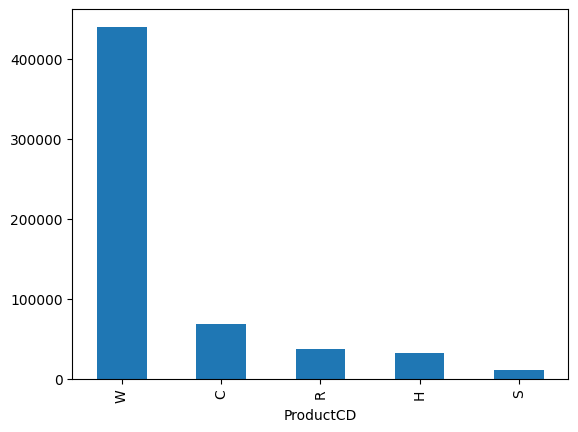

In [19]:
df.ProductCD.value_counts().plot(kind='bar')

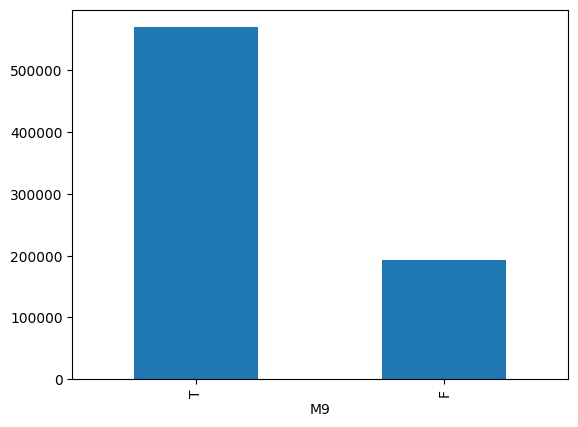

In [18]:
categorical_cols = ["ProductCD", "isFraud",
                    "card1", "card2", "card3", "card4", "card5", "card6",
                    "addr1", "addr2",
                    "P_emaildomain", "R_emaildomain",
                    "M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8", "M9"
                   ]

for name in categorical_cols:
    fig = df[name].value_counts().plot(kind='bar').get_figure()
    fig.savefig("./images/" + name + "value_count.jpg")

In [8]:
vars = percent_missing.index[percent_missing < 60]
print(len(vars))
#for i in range(len(vars)):
#    print(vars[i])

226


In [ ]:
data = df[vars]
labels = data["isFraud"]
data = data.drop("isFraud", axis=1)

In [56]:
def onehot_encode(df):
    # get object columns
    #cols = df.select_dtypes(include='object').columns
    cols = ['ProductCD', "M1", "card4"]
    df1 = df
    for name in cols:
        current_col = df1[name]
        onehot = pd.get_dummies(current_col)
        #df1 = df1.drop(name, axis=1)
        df1 = df1.join(onehot)
    df1 = df1.drop(cols, axis=1)    
    return df1

df1 = onehot_encode(df)
df1.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'card6', 'addr1',
       ...
       'H', 'R', 'S', 'W', 'F', 'T', 'american express', 'discover',
       'mastercard', 'visa'],
      dtype='object', length=402)

In [55]:
df1.M1

AttributeError: 'DataFrame' object has no attribute 'M1'

In [18]:
dtrain = xgb.DMatrix(data, label=labels)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:ProductCD: object, card4: object, card6: object, P_emaildomain: object, M1: object, M2: object, M3: object, M4: object, M5: object, M6: object, M7: object, M8: object, M9: object